In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import KNNWithMeans, SVDpp, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split, cross_validate

warnings.filterwarnings('ignore')

In [2]:
book_rating_data = pd.read_csv("../b. Datasets/Book Ratings.csv")

In [3]:
book_rating_data.shape

(120000, 5)

In [4]:
book_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Unnamed: 0.1  120000 non-null  int64
 1   Unnamed: 0    120000 non-null  int64
 2   book_id       120000 non-null  int64
 3   user_id       120000 non-null  int64
 4   rating        120000 non-null  int64
dtypes: int64(5)
memory usage: 4.6 MB


In [5]:
display(book_rating_data.head(2))
display(book_rating_data.tail(2))

,Unnamed: 0.1,Unnamed: 0,book_id,user_id,rating
0,0,0,1,314,5
1,1,1,1,439,3


,Unnamed: 0.1,Unnamed: 0,book_id,user_id,rating
119998,119998,119998,1201,7778,5
119999,119999,119999,1201,8060,3


In [6]:
book_rating_data.isna().sum()

Unnamed: 0.1    0
Unnamed: 0      0
book_id         0
user_id         0
rating          0
dtype: int64

In [7]:
book_rating_data.drop(labels=['Unnamed: 0.1', 'Unnamed: 0'], 
                      axis=1, 
                      inplace=True)

In [8]:
display(book_rating_data.head(2))
display(book_rating_data.tail(2))

,book_id,user_id,rating
0,1,314,5
1,1,439,3


,book_id,user_id,rating
119998,1201,7778,5
119999,1201,8060,3


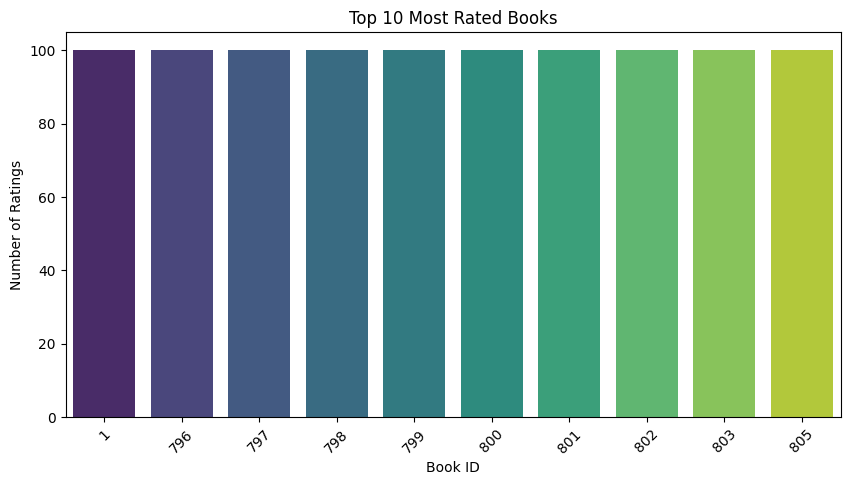

In [9]:
top_items = book_rating_data['book_id'].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.index, y=top_items.values, palette='viridis')
plt.xlabel("Book ID")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.title("Top 10 Most Rated Books")
plt.show()

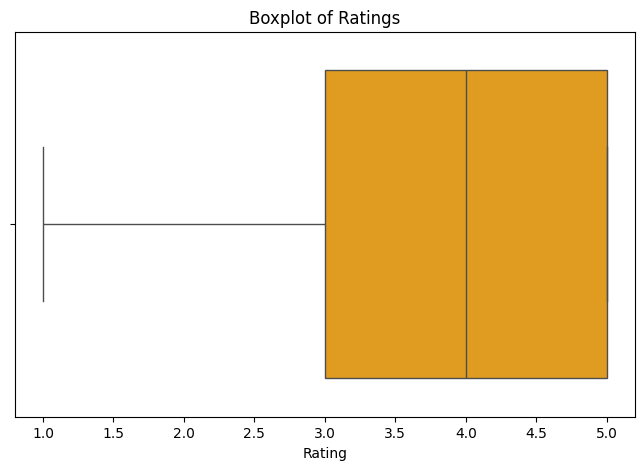

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=book_rating_data['rating'], color='orange')
plt.xlabel("Rating")
plt.title("Boxplot of Ratings")
plt.show()

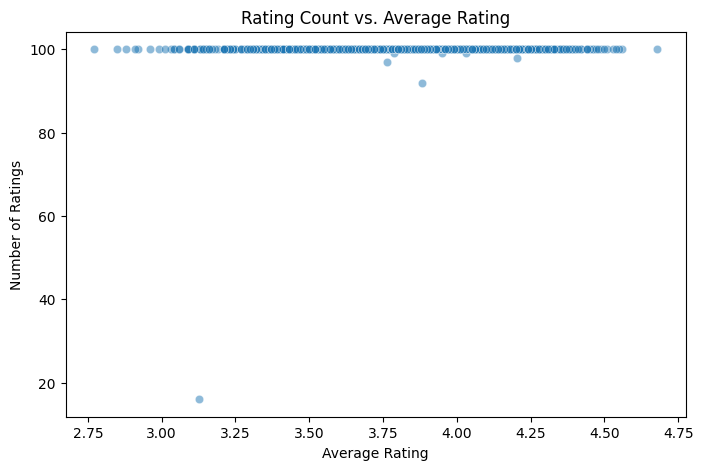

In [11]:
item_stats = book_rating_data.groupby('book_id').agg({'rating': ['count', 'mean']})
item_stats.columns = ['rating_count', 'rating_mean']

plt.figure(figsize=(8, 5))
sns.scatterplot(x=item_stats['rating_mean'], 
                y=item_stats['rating_count'], 
                alpha=0.5)
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")
plt.title("Rating Count vs. Average Rating")
plt.show()

In [12]:
reader = Reader(rating_scale=(1, 5))

In [13]:
display(book_rating_data.head(2))
display(book_rating_data.tail(2))

,book_id,user_id,rating
0,1,314,5
1,1,439,3


,book_id,user_id,rating
119998,1201,7778,5
119999,1201,8060,3


In [14]:
ratings_df = Dataset.load_from_df(book_rating_data[['user_id', 'book_id', 'rating']], 
                                  reader)
ratings_df

In [15]:
trainset, testset = train_test_split(ratings_df, 
                                     test_size=0.25, 
                                     shuffle=True, 
                                     random_state=0)

In [16]:
trainset_full = ratings_df.build_full_trainset()
print("Number of users:", trainset_full.n_users)
print('Number of items:', trainset_full.n_items)

Number of users: 7956
Number of items: 1201


In [17]:
kmeans_model = KNNWithMeans(sim_options={'name': 'cosine', 
                                         'user_based': False})
kmeans_model.fit(trainset_full)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [18]:
predictions = kmeans_model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7362


0.73621698913108

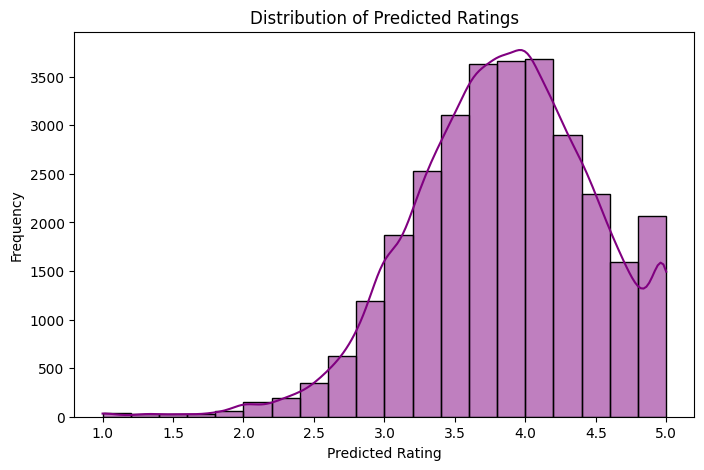

In [19]:
pred_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(8, 5))
sns.histplot(pred_ratings, bins=20, kde=True, color='purple')
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Ratings")
plt.show()

In [20]:
cross_validate(algo=kmeans_model,
               data=ratings_df, 
               verbose=True, 
               measures=['mae'], 
               cv=5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6912  0.6939  0.6956  0.6956  0.6977  0.6948  0.0022  
Fit time          0.32    0.34    0.47    0.59    0.61    0.47    0.12    
Test time         1.00    1.44    1.55    1.88    1.81    1.54    0.31    


{'test_mae': array([0.69122003, 0.69392785, 0.69556923, 0.6955637 , 0.69772891]),
 'fit_time': (0.3209371566772461,
  0.34316229820251465,
  0.4745769500732422,
  0.5899667739868164,
  0.6052210330963135),
 'test_time': (0.9988358020782471,
  1.4431593418121338,
  1.5508887767791748,
  1.8804676532745361,
  1.8087341785430908)}